# ReadMe
This file is intended to streamline the process of analyzing the data resulting from running the experiments in "falsifier.py" and "mult_obj_falsifier.py"

# Imports - TO DO add helpers, streamline process

In [1]:
import pandas as pd
import os
from pathlib import Path
import re
import numpy as np
import matplotlib.pyplot as plt
import math
from natsort import os_sorted


# Classify File Instances

In [2]:
def generate_velocity_csv(folder):
    ce_reg = r'.*\d_cex.*'
    nc_reg = r'.*no_cex.*'
    att_reg = r".*attacker_crash.*"


    non_ce_reg = [nc_reg,att_reg]

    followers = ["v2","v3","v4"]
    

    start = os.getcwd()
    v1,v2,v3,v4 = [],[],[],[]

    files = os_sorted(os.listdir(folder))

    os.chdir(folder)
    ce_count = 0
    for file in files: #match counter-examples first
        found = re.match(ce_reg,  file)
        if found:
            file_data = pd.read_csv(file)
            v1.append(np.array(file_data["v1"]))
            v2.append(np.array(file_data["v2"]))
            v3.append(np.array(file_data["v3"]))
            v4.append(np.array(file_data["v4"]))
            ce_count+= 1

    
    for file in files: #match non counter examples second
        for reg in non_ce_reg:
            found = re.match(reg, file)
            if found:
                file_data = pd.read_csv(file)
                v1.append(np.array(file_data["v1"]))
                v2.append(np.array(file_data["v2"]))
                v3.append(np.array(file_data["v3"]))
                v4.append(np.array(file_data["v4"]))
                break

    os.chdir(start)

    return [v1,v2,v3,v4], ce_count


In [ ]:

def read_folder(folder,sampler_file, attack_type):    
    """
    Data prepocessing: returns dataframe with test case specific features
    """

    velocity_data,ce_count = generate_velocity_csv(folder)


    simulation_params_df = pd.read_csv(sampler_file)

    if attack_type == "int":
        return(preprocess_intermittent(simulation_params_df,velocity_data)),ce_count
    if attack_type == "per":
        return(preprocess_persistent(simulation_params_df,velocity_data)),ce_count
    else:
        print("Error classifying attack type")


def preprocess_intermittent(sampler_data,velocities_df,):
    intermittent_cols = ["point.params.random_thr_br1","point.params.random_thr_br2","point.params.inter_vehicle_distance", "point.params.random_t1", "point.params.random_t2","point.params.random_t3","point.params.random_t4","point.params.random_thr_br1","rho"]
    sampler_data =sampler_data[intermittent_cols]
    output = get_attack_spacing_intermittent(sampler_data)
    output = velocity_at_attack_intermittent(sampler_data,velocities_df)
    

    return output

def preprocess_persistent(sampler_data,velocities_df):
    persistent_cols = [ "Unnamed: 0","point.params.amplitude_acc", "point.params.attack_time", "point.params.frequency", "point.params.inter_vehicle_distance", "rho"]
    sampler_data = sampler_data[persistent_cols]
    output = velocity_at_attack_persistent(velocities_df,sampler_data,True)
    return output




# Helper Functions

In [12]:
def get_attack_spacing_intermittent(intermittent_df): # Calculate distance between each attack and add to Dataframe
    attack_spacing = []

    for simulation_instance in range(len(intermittent_df)):
        diff_1 = intermittent_df["point.params.random_t2"][simulation_instance] - intermittent_df["point.params.random_t1"][simulation_instance] # t2 > t1
        diff_2 = intermittent_df["point.params.random_t3"][simulation_instance] - intermittent_df["point.params.random_t2"][simulation_instance]
        diff_3 = intermittent_df["point.params.random_t4"][simulation_instance] - intermittent_df["point.params.random_t3"][simulation_instance]

        sim_gaps = np.array([diff_1,diff_2,diff_3])
        attack_spacing.append(sim_gaps)

    attack_spacing = np.array(attack_spacing)
    col_names = ["t1_t2", "t2_t3", "t3_t4"]
    time_df = pd.DataFrame(attack_spacing, columns=col_names)

    return(pd.concat([intermittent_df, time_df],axis=1))


def velocity_at_attack_intermittent(intermittent_df,velocities_df): # Collect the attackers speed at each attack and append to Dataframe
    times = intermittent_df[["point.params.random_t1", "point.params.random_t2", "point.params.random_t3","point.params.random_t4"]]

    attk_vel = []
    for sim in range(len(times)):
        sim_vel = []
        sim_length = len(velocities_df[0][sim])
        for col in times.columns:
            idx = math.ceil(times[col][sim]) * 10
            if idx < sim_length:
                sim_vel.append(velocities_df[0][sim][idx])
            else:
                sim_vel.append(0)
        attk_vel.append(sim_vel)
        
    col_names = ["t1_velocity", "t2_velocity", "t3_velocity", "t4_velocity"]
    attk_vel = np.array(attk_vel)
    final_df = pd.DataFrame(attk_vel, columns=col_names)

    if display:
        generate_intermittent_attack_graphs(velocities_df,times,intermittent_df)

    return (pd.concat([intermittent_df,final_df],axis=1))


def velocity_at_attack_persistent(velocities_df, persistent_df, display):
    attack_times= persistent_df["point.params.attack_time"]


    velocity_at_attack = []  # construct custom features
    avg_speed_after_attck = []

    
    for sim_instance in range(len(attack_times)):
        attack_span = int(attack_times[sim_instance] * 10) # account for timestep length
        velocity_at_attack.append(np.average(velocities_df[0][sim_instance][attack_span-1:attack_span+1])) # average out over a few steps not just instantaneously 
        avg_speed_after_attck.append(np.average(velocities_df[0][sim_instance][attack_span:])) # collect that average speed after attack has occured

    velocity_at_attack = np.array(velocity_at_attack)
    avg_speed_after_attck = np.array(avg_speed_after_attck)
    col_names = [["pre_attack_velocity"],["attack_velocity_average"]]
    temp_df = pd.DataFrame(velocity_at_attack, columns=col_names[0])
    temp_df2 = pd.DataFrame(avg_speed_after_attck,columns=col_names[1]) 

    if display:
        generate_persistent_attack_graphs(velocities_df, persistent_df["point.params.frequency"],persistent_df["point.params.amplitude_acc"],persistent_df["point.params.attack_time"])
        


    return(pd.concat([persistent_df,temp_df,temp_df2],axis=1))                                    


# Visualization Tools

In [ ]:
def generate_persistent_attack_graphs(sim_velocities,att_freq,att_amplitude,times): # okay we gonna have to fix this up later
    """
    Graph Velocity over time w/ displayed amplitude and frequency   
    """
    for i in range(0,3):
        plt.figure()  #  (1, 500, 252)    

        x = range(len(sim_velocities[0][i]))
        plt.plot(x,sim_velocities[0][i], label = "Attacker")
        plt.plot(x,sim_velocities[1][i], linestyle="--", color="purple" , label= "Follower 1")

        plt.title(f"Velocity (m/s) Over time with attack Frequency {int(att_freq[i])} and acceleration amplitude {att_amplitude[i]:.2g} ")

        plt.xlabel(f"Timesteps (.1 secs): Attack at {math.ceil(times[i]*10)}")
        plt.ylabel(f"Velocity")

        plt.legend()


        attack_time = math.ceil(times[i] * 10)  
       # plt.axvspan(attack_time, attack_time + 10, color='blue', alpha=0.3, label="Attack Interval")

        plt.axvline(x=attack_time, color='red', alpha=0.7, label="Attack Time")


        plt.show()

def generate_intermittent_attack_graphs(velocities_list,times,intermittent_df):
    """
    Graph velocity over time w/ attack markers displaying attack start"
    
    """

    for i in range(0, 3):

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Create a figure with 2 subplots side by side
                # Determine shared limits for x-axis and y-axis
        x_min = 0
        x_max = max(len(velocities_list[0][i]), len(velocities_list[2][i]))

        y_min = min(
            min(velocities_list[0][i]), min(velocities_list[1][i]),
            min(velocities_list[2][i]), min(velocities_list[3][i])
        )
        y_max = max(
            max(velocities_list[0][i]), max(velocities_list[1][i]),
            max(velocities_list[2][i]), max(velocities_list[3][i])
        )

        # Apply limits to both subplots
        axes[0].set_xlim(x_min, x_max)
        axes[1].set_xlim(x_min, x_max)
        axes[0].set_ylim(y_min, y_max)
        axes[1].set_ylim(y_min, y_max)

        # First subplot - Attacker velocity
        x = range(len(velocities_list[0][i]))
        axes[0].plot(x, velocities_list[0][i], label="Attacker")
        axes[0].plot(x, velocities_list[1][i], linestyle="--", color="purple", label="Follower 1")

        axes[0].set_title("Attacker Velocity (m/s) with attack markers")
        axes[0].set_xlabel("Timesteps (.1 secs)")
        axes[0].set_ylabel("Velocity (m/s)")
      
        first = True
        for j in times.columns:
            attack_time = math.ceil(times[j][i] * 10)
            label = "Attack" if first else "_nolegend_"
            axes[0].scatter(attack_time, velocities_list[0][i][attack_time], color='red', marker='x', s=100, label=label)
            first = False


        axes[0].legend()

        # Second subplot - Followers velocity
        x = range(len(velocities_list[2][i]))
        axes[1].plot(x, velocities_list[1][i], linestyle="--", alpha=.7,  color="green", label="Follower 1")
        axes[1].plot(x, velocities_list[2][i], linestyle="--", alpha=.7, color="blue", label="Follower 2")
        axes[1].plot(x, velocities_list[3][i], linestyle="--", alpha=.7, color="purple", label="Follower 3")

        axes[1].set_title("Followers Velocity (m/s) over time with attack markers")
        axes[1].set_xlabel("Timesteps (.1 secs)")
        axes[1].set_ylabel("Velocity (m/s)")

        first = True
        for j in times.columns:
            attack_time = math.ceil(times[j][i] * 10)
            label = "Attack" if first else "_nolegend_"
            axes[1].scatter(attack_time, velocities_list[0][i][attack_time], color='red', marker='x', s=100, label=label)
            first = False

        axes[1].legend()




        plt.tight_layout()  # Adjust layout to fit both plots properly
        plt.show()


# Test

In [53]:
file_path = "../outputs/persistent_ce/persistent_attack_ce_ce.csv"
dir_path = "../outputs/persistent_ce"

file_path2 = "../outputs/intermittent_ce/intermittent_attack_ce_ce.csv"
dir_path2 = "../outputs/intermittent_ce"


/home/kay27/2_24_sampling_env/lib/python3.8/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/kay27/2_24_sampling_env/lib/python3.8/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


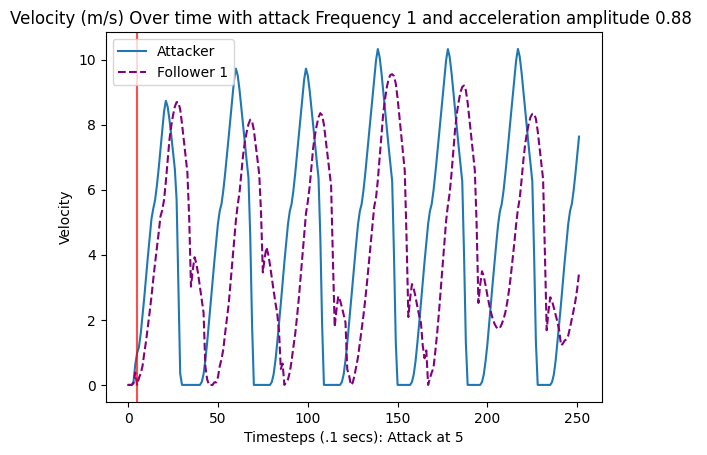

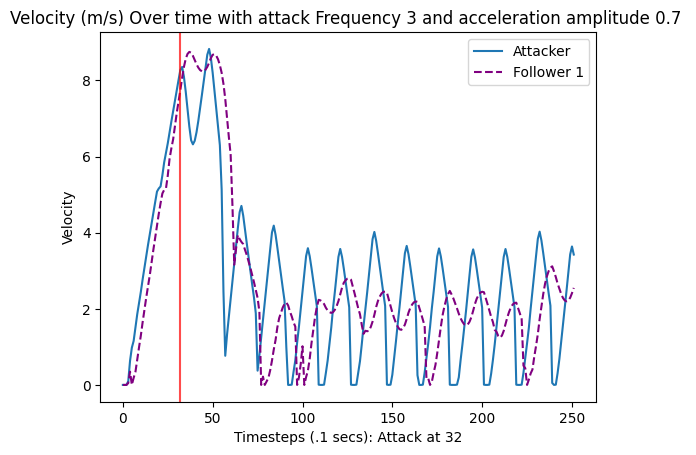

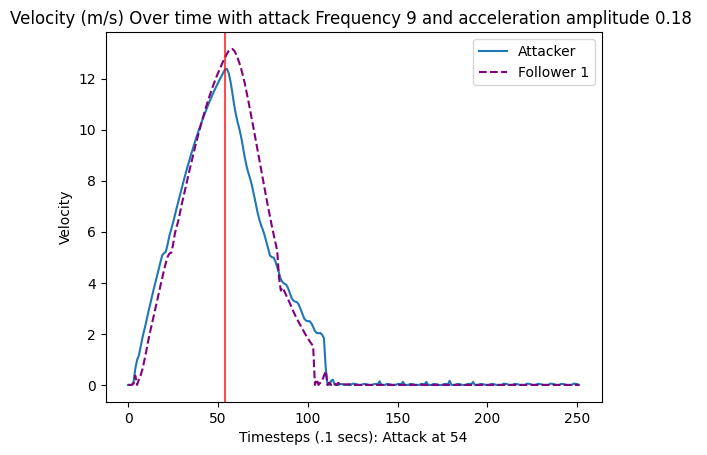

TypeError: scatter() got multiple values for argument 's'

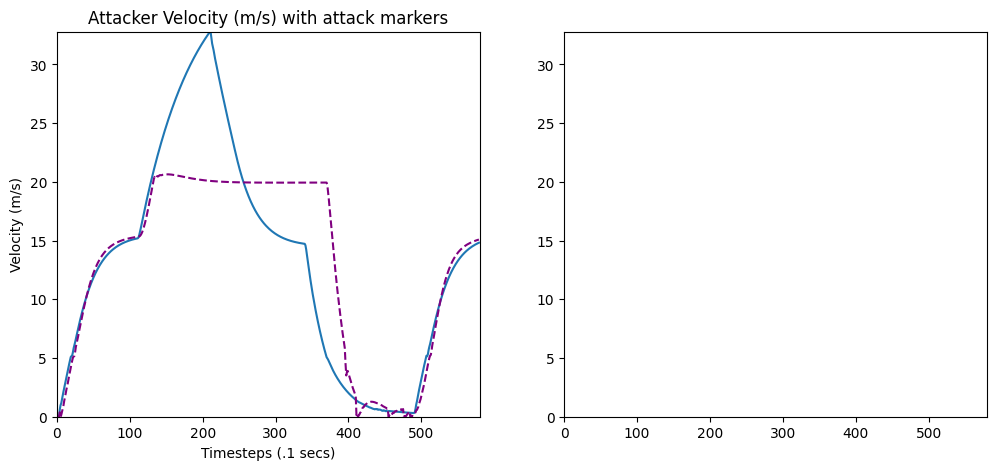

In [54]:
processed_data, ce_count1 = read_folder(dir_path, file_path,"per")
pd_2, ce_count2  = read_folder(dir_path2, file_path2, "int")

In [ ]:
ifitaintbrokedontfix.describe()

,Unnamed: 0,point.params.amplitude_acc,point.params.attack_time,point.params.frequency,point.params.inter_vehicle_distance,rho,pre_attack_velocity,attack_velocity_average
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,499.000000,500.000000
mean,148.262000,0.376204,4.773424,4.352893,11.013770,1.889599,10.784646,2.097442
std,102.982173,0.187024,1.576278,1.960999,4.550966,4.341390,2.979602,1.101029
min,0.000000,0.008632,0.081778,0.031856,7.032195,-0.274174,0.000000,0.025326
25%,62.000000,0.259697,4.200217,2.913203,8.475631,-0.099494,10.408773,1.540246
50%,124.500000,0.333800,4.994293,3.971586,9.770625,0.241876,11.606564,1.892713
75%,233.250000,0.416420,5.661094,5.514707,11.111880,0.663360,12.538622,2.358820
max,358.000000,0.997774,9.495678,9.883867,29.971224,22.261353,14.865350,10.420398


In [ ]:
test2.describe()

,point.params.random_thr_br1,point.params.random_thr_br2,point.params.inter_vehicle_distance,point.params.random_t1,point.params.random_t2,point.params.random_t3,point.params.random_t4,point.params.random_thr_br1,rho,t1_velocity,t2_velocity,t3_velocity,t4_velocity
count,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.400951,0.205525,11.443458,15.177044,27.337273,35.171425,45.344515,0.400951,2.799653,14.886906,13.145489,12.898172,5.061244
std,0.267320,0.216434,5.067588,2.506839,2.283908,2.576857,2.753568,0.267320,5.195142,1.754690,11.335962,4.091992,6.412569
min,0.002045,0.000339,7.013645,10.085756,21.007812,31.033596,41.026295,0.002045,-0.280609,11.335560,0.000000,0.000000,0.000000
25%,0.145889,0.065088,8.456623,12.991299,26.181330,33.271543,43.145866,0.145889,0.130371,14.210650,3.834784,11.099902,1.185021
50%,0.417830,0.135720,9.922782,15.848744,28.250485,34.072486,44.384799,0.417830,0.241449,15.415049,11.281044,13.259911,3.857132
75%,0.627998,0.230415,11.390347,17.105381,29.061115,38.259761,48.398657,0.627998,2.945938,15.444851,19.130074,15.314844,5.935493
max,0.993849,0.999645,29.859841,19.991689,29.996179,39.983366,49.999609,0.993849,24.459427,20.294294,55.787794,32.154995,58.791145


# Curr work

Persistent_attack uses frequency to define how often the attack is applied. What are some interesting feature we can extract from this? 
 Total attacks?
 Time between attacks?
 Velocity at attack time would still be interesting just a bit more complex to extract.


Likely need to rerun data as there was a useless variable EGO_BRAKING_THESHOLD being included in the search space.. I am not sure how much of an effect this would have had but can always re run and see what happens

In [ ]:
file_path = "../outputs/persistent_ce/persistent_attack_ce.csv"
dir_path = "../outputs/persistent_ce"

simulation_params_df = pd.read_csv("../outputs/persistent_ce/persistent_attack_ce.csv")

In [ ]:
persistent_cols = [ "point.params.amplitude_acc", "point.params.attack_time", "point.params.frequency", "point.params.inter_vehicle_distance", "rho"]
intemittent_cols = ["point.params.random_thr_br1","point.params.random_thr_br2","point.params.inter_vehicle_distance", "point.params.random_t1", "point.params.random_t2","point.params.random_t3","point.params.random_t4","point.params.random_thr_br1","rho"]

In [ ]:
evaluation_simulation_params_df = simulation_params_df[persistent_cols]
print(len(evaluation_simulation_params_df))

500


In [ ]:
files = os.listdir(dir_path)
classified_files = classify_simulations(files)

In [ ]:
evaluation_simulation_params_df.describe()

,point.params.amplitude_acc,point.params.attack_time,point.params.frequency,point.params.inter_vehicle_distance,rho
count,500.000000,500.000000,500.000000,500.000000,500.000000
mean,0.341717,6.507021,6.109624,11.331299,2.282775
std,0.274452,1.975794,2.955776,4.929331,4.627224
min,0.001723,0.036584,0.057499,7.008833,-0.273221
25%,0.124351,6.188735,3.267220,8.425303,0.066527
50%,0.265883,6.950120,6.355811,9.749395,0.242624
75%,0.534049,7.575427,9.023248,11.140633,1.478580
max,0.994191,9.980661,9.993043,29.065113,23.108299


In [ ]:
vel_path = "../outputs/persistent_ce/persistent_attack.scenic500_velocities.csv"
vel_df = pd.read_csv(vel_path)

# Constructing features for the persistent Attack

In [ ]:
attack_freq = evaluation_simulation_params_df["point.params.frequency"]
attack_amplitude = evaluation_simulation_params_df["point.params.amplitude_acc"]


In [ ]:
generate_persistent_attack_graphs(simulation_velocities_arr,attack_freq,attack_amplitude)

# Isolate different crash instances

In [ ]:
evaluation_simulation_params_ce_df = evaluation_simulation_params_df[:len(classified_files[0])]
non_ce_idx = len(classified_files[1]) + len(classified_files[2])
evaluation_simulation_params_nce_df = evaluation_simulation_params_df[:non_ce_idx]